# Nonlinear coupled ODEs (Lotka-Volterra)

[Download this notebook](https://github.com/BodeTobias/AutoPDEx/tree/main/docs/notebooks/ode_lotka_volterra.ipynb)


In this example the dae module is used to solve the Lotka-Volterra problem, a set of nonlinear ODEs

In [1]:
import jax
import jax.numpy as jnp
from autopdex import dae

jax.config.update("jax_enable_x64", True)


The dae module can solve ordinary differential equations expressed in an implicit form. Here, we have the following set of equations: 

$0 = -\frac{du}{dt} + αu − βuv$ 

$0 = -\frac{dv}{dt} −γv + δuv$

Where:

    u(t): prey population

    v(t): predator population

    α,β,γ,δ: model parameters

For autopdex, we can prepare this in a JAX-traceable function as follows:

In [2]:
def implicit_ode(q_fun, t, settings):
  # 'q_fun' is a function of time that returns the state variables accessible via their keywords.
  q_t_fun = jax.jacfwd(q_fun)
  q = q_fun(t)
  q_t = q_t_fun(t)

  u = q['u']
  v = q['v']
  u_t = q_t['u']
  v_t = q_t['v']

  # Here, we hardcode the parameters, but we could also load them from the settings dictionary and take derivatives with respect to them
  α, β, γ, δ = (0.1, 0.02, 0.4, 0.02)

  # Define the residuals of the system of ODEs
  res_u = u_t - (α * u - β * u * v)
  res_v = v_t - (-γ * v + δ * u * v)
  return jnp.array([res_u, res_v])
#

As in the PDE modules, the time stepping manager uses the dictionaries 'settings' and 'static_settings' in order to set up the problem. Here, we define the Lotka-Voltera-system as the 'dae' to be solved. Further, we chose the integrators for the different fields.

In [3]:
static_settings = {
    'dae': implicit_ode,
    'time integrators': {
        # 'u': dae.ForwardEuler(),
        # 'v': dae.ForwardEuler(),
        # 'u': dae.BackwardEuler(),
        # 'v': dae.BackwardEuler(),
        # 'u': dae.AdamsBashforth(4),
        # 'v': dae.AdamsBashforth(4),
        # 'u': dae.AdamsMoulton(1),
        # 'v': dae.AdamsMoulton(1),
        # 'u': dae.BackwardDiffFormula(3),
        # 'v': dae.BackwardDiffFormula(3),
        # 'u': dae.DiagonallyImplicitRungeKutta(3),
        # 'v': dae.DiagonallyImplicitRungeKutta(3),
        'u': dae.Kvaerno(5),
        'v': dae.Kvaerno(5),
        # 'u': dae.GaussLegendreRungeKutta(14),
        # 'v': dae.GaussLegendreRungeKutta(14),
        # 'u': dae.DormandPrince(5),
        # 'v': dae.DormandPrince(5),
        # 'u': dae.ExplicitRungeKutta(11),
        # 'v': dae.ExplicitRungeKutta(11),
    },
    'verbose': 0,
}

Next, we have to define the policies for time stepping and data saving.

In [4]:
manager = dae.TimeSteppingManager(
    static_settings,
    save_policy=dae.SaveEquidistantPolicy(),
    step_size_controller=dae.PIDController(rtol=1e-6, atol=1e-9)
    # step_size_controller=dae.ConstantStepSizeController()
    # step_size_controller=dae.RootIterationController(max_step_size = 2.)
)

After specifying the initial values, end time, initial time increment and maximal number of time steps, we can run the time stepping procedure.

In [5]:
dofs_0 = {
    'u': jnp.array([10.0]),
    'v': jnp.array([10.0]),
}
t_max = 140.0
num_time_steps = 2000
result = manager.run(dofs_0, t_max / num_time_steps, t_max, num_time_steps)

Progress: 3%, Time: 4.67e+00, accepted step: True, dt: 1.65e+00, iterations: 2
Progress: 8%, Time: 1.18e+01, accepted step: True, dt: 2.87e+00, iterations: 2
Progress: 13%, Time: 1.89e+01, accepted step: True, dt: 1.97e+00, iterations: 3
Progress: 18%, Time: 2.56e+01, accepted step: True, dt: 1.12e+00, iterations: 3
Progress: 23%, Time: 3.25e+01, accepted step: True, dt: 1.03e+00, iterations: 3
Progress: 29%, Time: 4.07e+01, accepted step: True, dt: 1.68e+00, iterations: 2
Progress: 34%, Time: 4.84e+01, accepted step: True, dt: 2.33e+00, iterations: 3
Progress: 39%, Time: 5.47e+01, accepted step: True, dt: 2.11e+00, iterations: 3
Progress: 44%, Time: 6.22e+01, accepted step: True, dt: 1.11e+00, iterations: 3
Progress: 49%, Time: 6.89e+01, accepted step: True, dt: 1.06e+00, iterations: 3
Progress: 54%, Time: 7.63e+01, accepted step: True, dt: 1.70e+00, iterations: 2
Progress: 60%, Time: 8.46e+01, accepted step: True, dt: 2.23e+00, iterations: 3
Progress: 66%, Time: 9.28e+01, accepted st

Here, we extract the data accumulated during time stepping and visualize it.

{'u': Array([10.12481327], dtype=float64), 'v': Array([10.24348822], dtype=float64)}


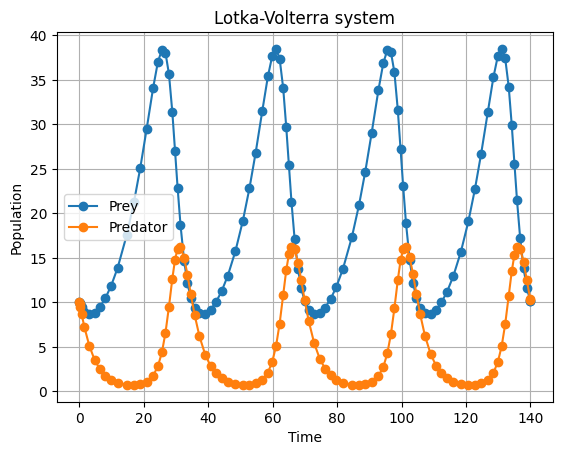

In [6]:
# Extract data
print(result.q)
history = result.history
u_sol = history.q['u']
v_sol = history.q['v']
ts = history.t

# Plot the results
import matplotlib.pyplot as plt
plt.plot(ts, u_sol, label="Prey", marker="o")
plt.plot(ts, v_sol, label="Predator", marker="o")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Lotka-Volterra system")
plt.legend()
plt.grid(True)
plt.show()
